# Imports and instalations

In [1]:
#!pip install lightgbm 

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from random import choice, randint

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
import pydotplus

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set(style="darkgrid")

# Data retrieving

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data', header=None)

# Little EDA

In [4]:
df.rename(columns={10: 'target'}, inplace=True)

### Data Set Information:

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background). 


Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions. 

The data set was generated by a Monte Carlo program, Corsika, described in: 
D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, 
Forschungszentrum Karlsruhe FZKA 6019 (1998). 
[Web Link] 

The program was run with parameters allowing to observe events with energies down to below 50 GeV.


###  Attribute Information:

1. fLength: continuous # major axis of ellipse [mm] 
2. fWidth: continuous # minor axis of ellipse [mm] 
3. fSize: continuous # 10-log of sum of content of all pixels [in #phot] 
4. fConc: continuous # ratio of sum of two highest pixels over fSize [ratio] 
5. fConc1: continuous # ratio of highest pixel over fSize [ratio] 
6. fAsym: continuous # distance from highest pixel to center, projected onto major axis [mm] 
7. fM3Long: continuous # 3rd root of third moment along major axis [mm] 
8. fM3Trans: continuous # 3rd root of third moment along minor axis [mm] 
9. fAlpha: continuous # angle of major axis with vector to origin [deg] 
10. fDist: continuous # distance from origin to center of ellipse [mm] 
11. class: g,h # gamma (signal), hadron (background) 

- g = gamma (signal): 12332 
- h = hadron (background): 6688 

For technical reasons, the number of h events is underestimated. In the real data, the h class represents the majority of the events. 

The simple classification accuracy is not meaningful for this data, since classifying a background event as signal is worse than classifying a signal event as background. For comparison of different classifiers an ROC curve has to be used. The relevant points on this curve are those, where the probability of accepting a background event as signal is below one of the following thresholds: 0.01, 0.02, 0.05, 0.1, 0.2 depending on the required quality of the sample of the accepted events for different experiments.

In [5]:
feature_names = {0: 'fLength',
                 1: 'fWidth',
                 2: 'fSize',
                 3: 'fConc',
                 4: 'fConc1',
                 5: 'fAsym',
                 6: 'fM3Long',
                 7: 'fM3Trans',
                 8: 'fAlpha',
                 9: 'fDist'}

class_names = ['gamma', 'signal']

df.rename(columns=feature_names, inplace=True)

In [6]:
replace_dict = {'g': 1, 'h': 0}
df.target.replace(replace_dict, inplace=True)

In [7]:
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,target
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026,0.648370
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787,0.477492
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600,0.000000
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250,0.000000
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450,1.000000
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825,1.000000
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  target    19020 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.6 MB


- No missed values
- No need to scale (due to used classifiers)
- imbalanced classed. target class is twice greater than non-target
- No categorical features
- No preprocessing after target replacement is needed

# Data preparation

### Helper functions

In [9]:
def get_curves_tree(param_dict: dict, random_state=42) -> None:
    train_results = []
    test_results = []
    for key in param_dict.keys():
        for item in param_dict[key]:
            dt = DecisionTreeClassifier(**{key:item}, random_state=random_state)
            dt.fit(X_train, y_train)
            train_pred = dt.predict_proba(X_train)
            roc_auc = roc_auc_score(y_train, train_pred[:, 1])
            train_results.append(roc_auc)
            y_pred = dt.predict_proba(X_test)
            roc_auc = roc_auc_score(y_test, y_pred[:, 1])
            test_results.append(roc_auc)


        plt.figure(figsize=(10,4))
        sns.lineplot(param_dict[key], train_results, label='Train AUC')
        sns.lineplot(param_dict[key], test_results, label='Test AUC')
        plt.ylabel('AUC score')
        plt.xlabel(key)
        plt.show()

In [10]:
def evaluate_model(classifier, train_set, train_target, test_set, test_target, metrics=[roc_auc_score]):
    prediction = train_model(classifier, train_set, train_target, test_set)
    results = get_model_metrics(classifier.__class__.__name__, test_target, prediction, metrics=[roc_auc_score])
    return results


def train_model(classifier, train_set, train_target, test_set):
    classifier.fit(train_set, train_target)
    return classifier.predict_proba(test_set)


def get_model_metrics(classifier_name, test_target, prediction, metrics=[roc_auc_score]):
    mectrics_result = dict()
    for metric in metrics:
        score = metric(test_target, prediction[:, 1])
        print("{} for model {} = {:.3f}".format(metric.__name__, classifier_name, score))
        mectrics_result[metric.__name__] = score
    mectrics_result['classifier'] = classifier_name
    return mectrics_result


In [11]:
def prepare_frame(dataframe: pd.DataFrame) -> pd.DataFrame:
    cut_labels_5 = ['a', 'b', 'c', 'd', 'e']
    cut_bins = [-1, 18, 30, 45, 75, 95]
    dataframe['cat_feature'] = pd.cut(dataframe['fAlpha'], bins=cut_bins, labels=cut_labels_5)
    dataframe['cat_feature'].astype(dtype='category', copy=False)
    for column in ['fConc', 'fConc1', 'fAsym']:
        for i in range(1000):
            ind = choice(range(dataframe.shape[0]))
            dataframe[column][ind] = np.nan
    dataframe = dataframe.drop(columns='fAlpha')
    return dataframe

In [12]:
CATEGORICAL_FEATURES = ['cat_feature']
NUM_FEATURES = ['fLength', 
                'fWidth', 
                'fSize', 
                'fConc', 
                'fConc1', 
                'fAsym', 
                'fM3Long', 
                'fM3Trans', 
                'fDist']

def process_categorical_only(dataframe, 
                             cat_features=CATEGORICAL_FEATURES):
    dataframe = dataframe.copy()
    cat_encoded = pd.get_dummies(dataframe[cat_features])
    dataframe.drop(columns=cat_features, inplace=True)
    dataframe = pd.concat((dataframe, cat_encoded), axis=1)
    return dataframe


def preprocess_frame(dataframe: pd.DataFrame, 
                     cat_features=CATEGORICAL_FEATURES,
                     num_features=NUM_FEATURES):
    dataframe = process_categorical_only(dataframe, cat_features)
    for feature in num_features:
        dataframe[feature].fillna(dataframe[feature].mean(), inplace=True)
    return dataframe


def split_frame(dataframe):
    X = dataframe.drop(columns='target')
    y = dataframe.target.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
    return X_train, X_test, y_train, y_test

In [13]:
results_by_model = pd.DataFrame()

### Adding missing values and categories

Let's add some missing values and one categorical feature to show most differences in algorithms

In [24]:
changed_frame = prepare_frame(df)
X_train, X_test, y_train, y_test = split_frame(changed_frame)

changed_frame.isna().sum()

<ipython-input-11-87f9b574545e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][ind] = np.nan


fLength           0
fWidth            0
fSize             0
fConc          1915
fConc1         1913
fAsym          1914
fM3Long           0
fM3Trans          0
fDist             0
target            0
cat_feature       0
dtype: int64

In [25]:
changed_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   fLength      19020 non-null  float64 
 1   fWidth       19020 non-null  float64 
 2   fSize        19020 non-null  float64 
 3   fConc        17105 non-null  float64 
 4   fConc1       17107 non-null  float64 
 5   fAsym        17106 non-null  float64 
 6   fM3Long      19020 non-null  float64 
 7   fM3Trans     19020 non-null  float64 
 8   fDist        19020 non-null  float64 
 9   target       19020 non-null  int64   
 10  cat_feature  19020 non-null  category
dtypes: category(1), float64(9), int64(1)
memory usage: 1.5 MB


# Decision Trees

### Preprocessing

In [26]:
base_tree = DecisionTreeClassifier(random_state=42)
try:
    result_dict = evaluate_model(base_tree, X_train, y_train, X_test, y_test)
    results_by_model = results_by_model.append(result_dict, ignore_index=True)
except ValueError:
    print('ERROR: incompitable value types')

ERROR: incompitable value types


Before we start to use trees we need to deal with na values and categorical feature

In [27]:
processed_frame = preprocess_frame(changed_frame) # one-hot encoding + mean imputation

X_train, X_test, y_train, y_test = split_frame(processed_frame)

In [28]:
base_tree = DecisionTreeClassifier(random_state=42)
result_dict = evaluate_model(base_tree, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model DecisionTreeClassifier = 0.808


C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


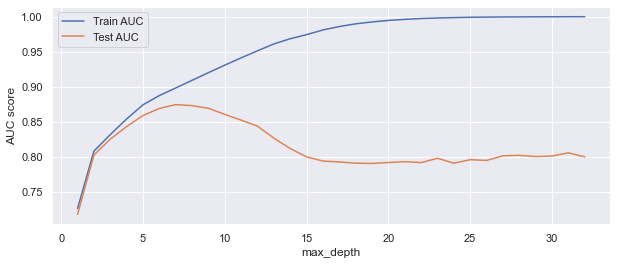

In [29]:
param_dict={'max_depth': np.linspace(1, 32, 32, endpoint=True)}
get_curves_tree(param_dict)

C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


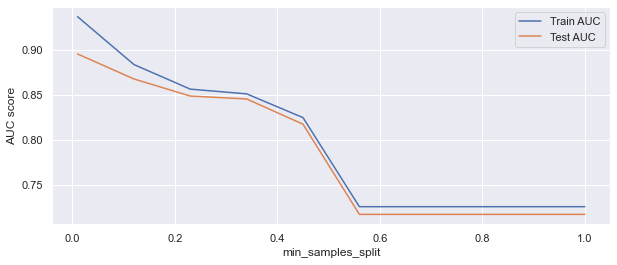

In [30]:
param_dict = {'min_samples_split': np.linspace(0.01, 1.0, 10, endpoint=True)}
get_curves_tree(param_dict)

C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


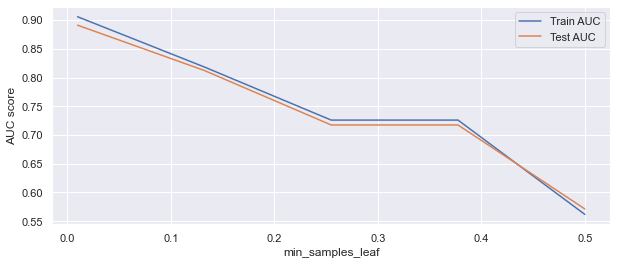

In [31]:
param_dict = {'min_samples_leaf': np.linspace(0.01, 0.5, 5, endpoint=True)}
get_curves_tree(param_dict)

C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\agama\anaconda3\envs\course\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


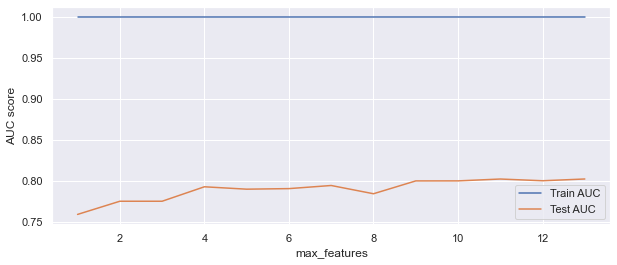

In [32]:
param_dict = {'max_features': list(range(1,X_train.shape[1]))}
get_curves_tree(param_dict)

Let's take a look into the tree with one feature. Why it's so good overfitted  on train

In [35]:
features = processed_frame.columns.values.tolist()
features.remove('target')

sample_tree = DecisionTreeClassifier(max_features=1)
result_dict = evaluate_model(sample_tree, X_train, y_train, X_test, y_test)

dot_data = tree.export_graphviz(sample_tree, out_file=None, 
                                feature_names=features,  
                                class_names=class_names,
                                filled=True)

# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.set_size('"14,14!"')
# graph = graphviz.Source(pydot_graph.to_string())
# graph

roc_auc_score for model DecisionTreeClassifier = 0.768


In [36]:
#full size graph only if you're ready to wait
# graph = graphviz.Source(dot_data)
# graph

In [37]:
final_tree = DecisionTreeClassifier(max_depth=7, max_features=9 , min_samples_split=0.01, min_samples_leaf=0.01, random_state=42)
result_dict = evaluate_model(final_tree, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model DecisionTreeClassifier = 0.877


### Visualize tree

In [38]:
# dot_data = tree.export_graphviz(final_tree, out_file=None, 
#                                 feature_names=features,  
#                                 class_names=class_names,
#                                 filled=True)

# pydot_graph = pydotplus.graph_from_dot_data(dot_data)
# pydot_graph.set_size('"14,14!"')
# graph = graphviz.Source(pydot_graph.to_string())
# graph


In [39]:
# graph = graphviz.Source(dot_data)
# graph

# Random Forest

Let's check need for preprocessing

In [40]:
X_train, X_test, y_train, y_test = split_frame(changed_frame)

In [41]:
rf = RandomForestClassifier(random_state=42, )

try:
    result_dict = evaluate_model(rf, X_train, y_train, X_test, y_test)
    results_by_model = results_by_model.append(result_dict, ignore_index=True)
except ValueError:
    print('ERROR: incompitable value types') # we cannot perform it with missings  (catrgorical (?))

ERROR: incompitable value types


In [42]:
X_train, X_test, y_train, y_test = split_frame(processed_frame)

In [43]:
rf = RandomForestClassifier(random_state=42, )
result_dict = evaluate_model(rf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model RandomForestClassifier = 0.931


In [44]:
param_grid = {
    'max_depth': [5, 10, None],
    'max_features': [2, 3, 'auto'], # [3,'auto']
    'min_samples_leaf': [1, 3, 5], # [3,5]
    'min_samples_split': [2, 6, 12], # [6,12]
    'n_estimators': [10, 100, 300] # [100,1000,3000]
}
# not overfitting?
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2, scoring='roc_auc')

In [46]:
%%time
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 300}

In [ ]:
result_dict = evaluate_model(grid_search.best_estimator_, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

roc_auc_score for model RandomForestClassifier = 0.933


# Gradient Boosting

## XGBoost

XGBoost can handle missing values with out preprocessing, but we still need to preprocess categorical features

In [47]:
xgboost_frame = process_categorical_only(changed_frame)
X_train, X_test, y_train, y_test = split_frame(xgboost_frame)

In [48]:
xg_clf = XGBClassifier(objective ='binary:logistic', random_state=42)
result_dict= evaluate_model(xg_clf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
roc_auc_score for model XGBClassifier = 0.932


C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


There are a plenty of tuning parameters for tree-based learners in XGBoost and you can read all about them [here](https://xgboost.readthedocs.io/en/latest/parameter.html). 
But the most common ones that you should know are:

- ```learning_rate```: step size shrinkage used to prevent overfitting. Range is [0,1]
- ```max_depth```: determines how deeply each tree is allowed to grow during any boosting round.
- ```subsample```: percentage of samples used per tree. Low value can lead to underfitting.
- ```colsample_bytree```: percentage of features used per tree. High value can lead to overfitting.
- ```n_estimators```: number of trees you want to build.
- ```objective```: determines the loss function to be used like 
    - reg:linear for regression problems, 
    - reg:logistic for classification problems with only decision
    - binary:logistic for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.
- ```gamma```: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. 

Supported only for tree-based learners.
- ```alpha```: L1 regularization on leaf weights. A large value leads to more regularization.
- ```lambda```: L2 regularization on leaf weights and is smoother than L1 regularization.

We will try to tune our parameters with hyperopt which use Parsen Tree Algorithm to optimize the parameters search. More info [here](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)

In [49]:
%%time

def objective(space):
    params = {
        'colsample_bytree': '{:.3f}'.format(space['colsample_bytree']),
        'learning_rate': '{:.3f}'.format(space['learning_rate']),
        'alpha' : '{:.3f}'.format(space['alpha']),
        'n_estimators': space['n_estimators']
    }
    
    clf = XGBClassifier(
        objective ='binary:logistic',
        random_state=42,
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=10).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return {'loss':1 - score, 'status': STATUS_OK }

space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0, 1),
    'alpha': hp.uniform('alpha', 0, 10),
    'n_estimators': hp.choice('n_estimators', [100, 1000, 3000])
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

[13:41:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:10<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:21<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:42:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:33<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:42:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:46<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:42:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [00:58<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[13:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|                                                                           | 0/10 [01:10<?, ?trial/s, best loss=?]

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(

C:\Users\agama\anaconda3\envs\course\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



  0%|                                                                           | 0/10 [01:10<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
best

{'alpha': 5.985727658089665,
 'colsample_bytree': 0.7723952132462335,
 'learning_rate': 0.19855089104236356,
 'n_estimators': 1}

In [ ]:
best_xg_clf = XGBClassifier(objective ='binary:logistic', 
                            alpha=best['alpha'],
                            colsample_bytree = best['colsample_bytree'],
                            learning_rate=best['learning_rate'],
                            n_estimators=1000,
                            random_state=42)

result_dict = evaluate_model(best_xg_clf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)                      

roc_auc_score for model XGBClassifier = 0.933


## LightGBM

Light GBM can work with both categorical features and missing values

In [50]:
changed_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   fLength      19020 non-null  float64 
 1   fWidth       19020 non-null  float64 
 2   fSize        19020 non-null  float64 
 3   fConc        17105 non-null  float64 
 4   fConc1       17107 non-null  float64 
 5   fAsym        17106 non-null  float64 
 6   fM3Long      19020 non-null  float64 
 7   fM3Trans     19020 non-null  float64 
 8   fDist        19020 non-null  float64 
 9   target       19020 non-null  int64   
 10  cat_feature  19020 non-null  category
dtypes: category(1), float64(9), int64(1)
memory usage: 1.5 MB


In [51]:
X_train, X_test, y_train, y_test = split_frame(changed_frame)

In [52]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15216 entries, 7973 to 791
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   fLength      15216 non-null  float64 
 1   fWidth       15216 non-null  float64 
 2   fSize        15216 non-null  float64 
 3   fConc        13653 non-null  float64 
 4   fConc1       13686 non-null  float64 
 5   fAsym        13702 non-null  float64 
 6   fM3Long      15216 non-null  float64 
 7   fM3Trans     15216 non-null  float64 
 8   fDist        15216 non-null  float64 
 9   cat_feature  15216 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.2 MB


In [53]:
lgb_clf = LGBMClassifier(n_estimators=1000, random_state=42)

result_dict = evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)                      

roc_auc_score for model LGBMClassifier = 0.936


Main parameter to tune in LightGBM is ```num_leaves```
We will omit the process of tuning for this algorithm and you can do it by yourselves if you want to.

In [54]:
lgb_clf = LGBMClassifier(n_estimators=1000, 
                         num_leaves=7
                         ,random_state=42)

result_dict = evaluate_model(lgb_clf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True) 

roc_auc_score for model LGBMClassifier = 0.937


## CatBoost

In [ ]:
cat_clf = CatBoostClassifier(random_state=42, verbose=False, cat_features=[9])


result_dict = evaluate_model(cat_clf, X_train, y_train, X_test, y_test)
results_by_model = results_by_model.append(result_dict, ignore_index=True)  

roc_auc_score for model CatBoostClassifier = 0.941


### Optional task to tune paramters of CatBoost.
As tree boosting cat boost obviously uses such parameters as:
- number of trees ```iterations``` how many trees could be built
- learning rate ```learning_rate``` how slow our descend would be
- tree depth ```depth``` how deep build tree. Recommended from 6 to 10
- L2 regularization ```l2_leaf_reg``` 

And some that has only CatBoost i.e.:
- Random Strength ```random_strength```: The value of this parameter is used when selecting splits. On every iteration each possible split gets a score (for example, the score indicates how much adding this split will improve the loss function for the training dataset). The split with the highest score is selected. The scores have no randomness. A normally distributed random variable is added to the score of the feature. It has a zero mean and a variance that decreases during the training. The value of this parameter is the multiplier of the variance
- Bagging Temperature ```bagging_temperature``` Defines the settings of the Bayesian bootstrap. It is used by default in classification and regression modes. Use the Bayesian bootstrap to assign random weights to objects. The weights are sampled from exponential distribution if the value of this parameter is set to “1”. All weights are equal to 1 if the value of this parameter is set to “0”.

And so on

Tuning of cat boost is optional and at your discretion

# Final results

In [ ]:
results_by_model.sort_values(by='roc_auc_score', ascending=False)

,classifier,roc_auc_score
8,CatBoostClassifier,0.941017
7,LGBMClassifier,0.938272
6,LGBMClassifier,0.935643
5,XGBClassifier,0.933179
3,RandomForestClassifier,0.932618
2,RandomForestClassifier,0.931922
4,XGBClassifier,0.917513
1,DecisionTreeClassifier,0.876369
0,DecisionTreeClassifier,0.799089


## Conclusions
- We looked through different tree models
- Used different techniques for hyper parameters tuning
- In our specific case best model was CatBoostClassifier
- But it's not a ground truth. Every task has its own specifics, so there would be specific best model for that task